# Loan Repayment Challenge

#### Import necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import geopandas as gpd
import IPython.display as display


from boruta import BorutaPy
from imblearn.over_sampling import SMOTE
from statsmodels.graphics.mosaicplot import mosaic


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator, FixedLocator

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go


import scipy.stats as stats
from scipy.stats import pearsonr


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler

import json
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',500)
pd.set_option('display.max_columns', None)

sns.set()
%matplotlib inline

np.random.seed(0)

## Data Collection

In [2]:
os.chdir('/Users/stephanie/Documents/MoneyLion')

loan_data = pd.read_csv('./data/loan.csv')
payment_data = pd.read_csv('./data/payment.csv')
underwriting_data = pd.read_csv('./data/clarity_underwriting_variables.csv', low_memory=False)


loan_payment_data = pd.merge(loan_data, payment_data, on='loanId', how='left')
merged_data = pd.merge(loan_payment_data, underwriting_data, left_on='clarityFraudId', right_on='underwritingid', how='left')


In [3]:
loan_df = pd.DataFrame(loan_data)
payment_df = pd.DataFrame(payment_data)
underwriting_df = pd.DataFrame(underwriting_data)

loan_payment_df = pd.DataFrame(loan_payment_data)
merged_df = pd.DataFrame(merged_data)

In [4]:
print(payment_df.shape)
print(loan_df.shape)
print(underwriting_df.shape)

print(loan_payment_df.shape)
print(merged_df.shape)

(689364, 9)
(577682, 19)
(49752, 54)
(1227094, 27)
(1227094, 81)


In [5]:
merged_df.head(10)

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,installmentIndex,isCollection,paymentDate,principal,fees,paymentAmount,paymentStatus,paymentReturnCode,.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago,.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago,.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago,.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago,.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict,.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbytradeopenlt90days,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssninvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.morethan3inquiriesinthelast30days,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedpriortossnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseformatinvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.inquirycurrentaddressnotonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.highprobabilityssnbelongstoanother,.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbynewtradeonly,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedbeforeage18,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithstate,.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseinconsistentwithonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedascellphone,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedashomephone,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamematch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncodedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncodedesc

In [6]:
pm = merged_df[(merged_df['paymentAmount'] < 0)]
pm[['anon_ssn','paymentAmount']]

,anon_ssn,paymentAmount
18682,83857660a4a63be92499662d48caee46,-212.77
131485,70674fd52e25f75f77b6471243c52393,-46.38
142436,6a43126763bdfb5427c28d4513b8f82d,-0.01
269870,18e07111ef1686b5d104262579321880,-94.16
442059,76df299352baf9aa123ecdd5e8f01efd,-141.56
543843,16333709623126879aa7452352ff1d65,-175.38
581080,7f7e8aa1227e670c5979f14dd9148669,-337.70
662965,ece58b560a364fa0a47eac9fb89813b8,-153.67
683627,df24f956b700a399e6c0595c72e32bf9,-6.12
738370,760a5e4d097ae6acdd04b6f0ccca994b,-0.01


In [7]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227094 entries, 0 to 1227093
Data columns (total 81 columns):
 #   Column                                                                                               Non-Null Count    Dtype  
---  ------                                                                                               --------------    -----  
 0   loanId                                                                                               1226838 non-null  object 
 1   anon_ssn                                                                                             1227094 non-null  object 
 2   payFrequency                                                                                         1225821 non-null  object 
 3   apr                                                                                                  1223172 non-null  float64
 4   applicationDate                                                                           

In [8]:
dtype_counts = pd.DataFrame(merged_df.dtypes.value_counts())
dtype_counts

,count
object,55
float64,21
int64,3
bool,2


- There are 1,227,094 entries and 81 columns.
- There are 21 columns of float datatype, 3 of integer datatype, 2 of boolean datatype, and the remaining 55 are object.
- There are some missing data

## Data Preprocessing

#### Rename and fix the faulty of data naming

In [10]:
underwriting_dictionary = pd.read_csv('./dictionaries/clarity_underwriting_dictionary.csv')

In [11]:
mapping_dict = underwriting_dictionary.dropna(subset=['Column Name']).set_index('fieldName_in_file')['Column Name'].to_dict()

In [12]:
merged_df.rename(columns=mapping_dict, inplace=True)

In [13]:
new_column_names = {
    'loanId': 'LoanID',
    'anon_ssn': 'HashedSSN',
    'payFrequency': 'PayFrequency',
    'apr': 'APR',
    'applicationDate': 'ApplicationDate',
    'originated': 'IsOriginated',
    'originatedDate': 'OriginatedDate',
    'nPaidOff': 'PaidOffCount',
    'approved': 'IsApproved',
    'isFunded': 'IsFunded',
    'loanStatus': 'LoanStatus',
    'loanAmount': 'LoanAmount',
    'originallyScheduledPaymentAmount': 'ScheduledPaymentAmount',
    'state': 'State',
    'leadType': 'LeadType',
    'leadCost': 'LeadCost',
    'fpStatus': 'FirstPaymentStatus',
    'clarityFraudId': 'ClarityFraudID',
    'hasCF': 'HasCF',
    'installmentIndex': 'InstallmentIndex',
    'isCollection': 'IsCollection',
    'paymentDate': 'PaymentDate',
    'principal': 'Principal',
    'fees': 'Fees',
    'paymentAmount': 'PaymentAmount',
    'paymentStatus': 'PaymentStatus',
    'paymentReturnCode': 'PaymentReturnCode',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription': 'CF.match.phone_match_type_description',
    '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch': 'CF.match.ssn_dob_match',
    'clearfraudscore': 'FraudScore',
    'underwritingid': 'UnderwritingID'
}

merged_df.rename(columns=new_column_names, inplace=True)

#### Drop unnecessary columns in the dataset.

In [14]:
merged_df.isnull().sum()

LoanID                                256
HashedSSN                               0
PayFrequency                         1273
APR                                  3922
ApplicationDate                         0
                                   ...   
CF.match.name_addr_reason_code    1163537
CF.match.ssn_dob_match             665192
CF.match.oa_reason_code            665192
FraudScore                         666361
UnderwritingID                     664746
Length: 81, dtype: int64

<Axes: xlabel='CF.fs.bof_ssn_deceased', ylabel='count'>

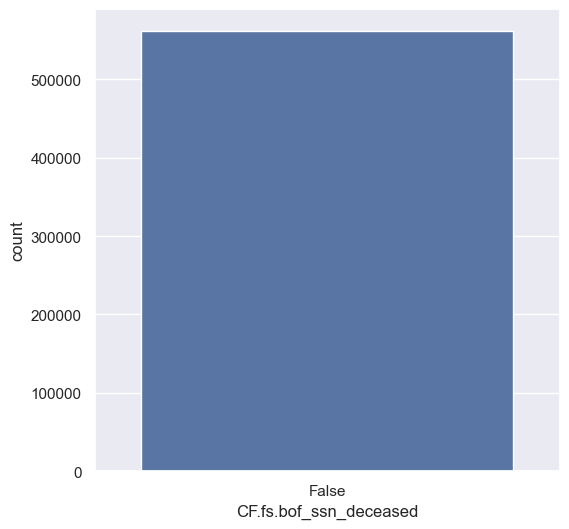

In [15]:
plt.figure(figsize=(6, 6))
sns.countplot(x = 'CF.fs.bof_ssn_deceased', data = merged_df)

In [16]:
phone_columns = [col for col in merged_df.columns if 'phone' in col]
phone_df = merged_df[phone_columns]
phone_df.head(10)

,CF.fs.phone_inconsistent_w_addr,CF.fs.phone_inconsistent_w_state,CF.match.phone_match_type,CF.match.phone_match_result,CF.match.phone_match_type_description,CF.match.phone_type
0,NaN,NaN,NaN,NaN,NaN,NaN
1,False,NaN,NaN,invalid,NaN,NaN
2,False,NaN,NaN,invalid,NaN,NaN
3,False,NaN,NaN,invalid,NaN,NaN
4,False,NaN,NaN,invalid,NaN,NaN
5,False,NaN,NaN,invalid,NaN,NaN
6,False,NaN,NaN,invalid,NaN,NaN
7,False,NaN,NaN,invalid,NaN,NaN
8,False,NaN,NaN,invalid,NaN,NaN
9,False,NaN,NaN,invalid,NaN,NaN


In [17]:
for column in phone_df.columns:
    print("Number of unique values: ", len(phone_df[column].unique()))
    print(column , ": " , phone_df[column].unique(), "\n")

Number of unique values:  3
CF.fs.phone_inconsistent_w_addr :  [nan False True] 

Number of unique values:  3
CF.fs.phone_inconsistent_w_state :  [nan False True] 

Number of unique values:  9
CF.match.phone_match_type :  [nan 'U' 'M' 'P' 'L' 'FA' 'F' 'LA' 'A'] 

Number of unique values:  6
CF.match.phone_match_result :  [nan 'invalid' 'unavailable' 'partial' 'match' 'mismatch'] 

Number of unique values:  9
CF.match.phone_match_type_description :  [nan '(U) Unlisted' '(M) Mobile Phone' '(P) Pager' '(L) Last Name Only'
 '(FA) Full Name and Address' '(F) Full Name Only'
 '(LA) Last Name and Address' '(A) Address Only'] 

Number of unique values:  4
CF.match.phone_type :  [nan 'R' 'MU' 'B'] 



In [18]:
merged_df.drop(['PaymentReturnCode', 
                      'CF.fs.dl_inconsistent_wof', 
                      'CF.match.ssn_name_code_desc',
                      'CF.match.name_addr_code_desc',
                      'CF.match.phone_type',
                      'CF.match.ssn_dob_reason_code',
                      'CF.match.ssn_name_reason_code',
                      'CF.match.name_addr_reason_code',
                      'CF.fs.work_num_prev_home_num',
                      'CF.fs.work_num_prev_cell_num',
                      'CF.match.phone_match_type_description',
                      'CF.fs.dl_format_invalid',
                      'HasCF',
                      'OriginatedDate',
                      'PaymentDate',
                      'CF.fs.phone_inconsistent_w_state',
                      'CF.match.phone_match_type'
                      ], axis=1, inplace=True)

#### Drop irrelevant, empty or duplicate rows.

In [19]:
merged_df.shape

(1227094, 64)

In [20]:
merged_df.isnull().sum()

LoanID                        256
HashedSSN                       0
PayFrequency                 1273
APR                          3922
ApplicationDate                 0
                            ...  
CF.match.oa_result         665192
CF.match.ssn_dob_match     665192
CF.match.oa_reason_code    665192
FraudScore                 666361
UnderwritingID             664746
Length: 64, dtype: int64

In [21]:
merged_df.dropna(subset=['LoanID'], inplace=True)

In [22]:
merged_df.dropna(subset=['FraudScore'], inplace=True)

In [23]:
merged_df.dropna(subset=['ClarityFraudID'], inplace=True)

In [24]:
merged_df.shape

(560726, 64)

In [25]:
null_counts = merged_df.isnull().sum()
null_counts[null_counts > 0]

PayFrequency             101
APR                       10
PaidOffCount              34
LoanStatus                 4
LoanAmount                10
State                     13
FirstPaymentStatus      6009
InstallmentIndex        3999
IsCollection            3999
Principal               3999
Fees                    3999
PaymentAmount           3999
PaymentStatus         135831
dtype: int64

### Fix data values

In [26]:
merged_df['FirstPaymentStatus'] = merged_df['FirstPaymentStatus'].replace('No Schedule', 'No Payments')

In [27]:
voided_statuses = [
    'Customer Voided New Loan', 
    'CSR Voided New Loan', 
    'Credit Return Void'
]

merged_df['LoanStatus'] = merged_df['LoanStatus'].replace(voided_statuses, 'Voided Loan')

In [28]:
merged_df[(merged_df['HashedSSN'] == '7529d29c9d943cc55bc71a85d9c6b7a3')].head(10)

,LoanID,HashedSSN,PayFrequency,APR,ApplicationDate,IsOriginated,PaidOffCount,IsApproved,IsFunded,LoanStatus,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,ClarityFraudID,InstallmentIndex,IsCollection,Principal,Fees,PaymentAmount,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,UnderwritingID
69,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01T15:55:41.823000,True,0.0,True,1,New Loan,400.0,1364.87,NJ,lead,40,Checked,58b6eef8e4b0b6fca82fd426,1.0,False,0.00,56.55,56.55,Pending,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,True,5.0,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,1.0,False,False,False,match,match,unavailable,match,match,1.0,658.0,58b6eef8e4b0b6fca82fd426
70,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01T15:55:41.823000,True,0.0,True,1,New Loan,400.0,1364.87,NJ,lead,40,Checked,58b6eef8e4b0b6fca82fd426,2.0,False,2.83,49.48,52.31,Pending,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,True,5.0,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,1.0,False,False,False,match,match,unavailable,match,match,1.0,658.0,58b6eef8e4b0b6fca82fd426
71,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01T15:55:41.823000,True,0.0,True,1,New Loan,400.0,1364.87,NJ,lead,40,Checked,58b6eef8e4b0b6fca82fd426,3.0,False,3.18,49.13,52.31,NaN,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,True,5.0,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,1.0,False,False,False,match,match,unavailable,match,match,1.0,658.0,58b6eef8e4b0b6fca82fd426
72,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01T15:55:41.823000,True,0.0,True,1,New Loan,400.0,1364.87,NJ,lead,40,Checked,58b6eef8e4b0b6fca82fd426,4.0,False,3.57,48.74,52.31,NaN,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,True,5.0,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,1.0,False,False,False,match,match,unavailable,match,match,1.0,658.0,58b6eef8e4b0b6fca82fd426
73,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01T15:55:41.823000,True,0.0,True,1,New Loan,400.0,1364.87,NJ,lead,40,Checked,58b6eef8e4b0b6fca82fd426,5.0,False,4.02,48.29,52.31,NaN,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,True,5.0,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,1.0,False,False,False,match,match,unavailable,match,match,1.0,658.0,58b6eef8e4b0b6fca82fd426
74,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01T15:55:41.823000,True,0.0,True,1,New Loan,400.0,1364.87,NJ,lead,40,Checked,58b6eef8e4b0b6fca82fd426,6.0,False,4.51,47.80,52.31,NaN,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,True,5.0,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,1.0,False,False,False,match,match,unavailable,match,match,1.0,658.0,58b6eef8e4b0b6fca82fd426
75,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,

In [29]:
merged_df['ApplicationDate'] = merged_df['ApplicationDate'].astype(str).str[:10]

In [30]:
merged_df['ApplicationDate'] = pd.to_datetime(merged_df['ApplicationDate'], format='%Y-%m-%d', errors='coerce')

In [31]:
merged_df = merged_df[merged_df['State'] != 'TX-TEST']

### Fill null values

In [32]:
for column in merged_df.columns:
    print("Number of unique values: ", len(merged_df[column].unique()))
    print(column , ": " , merged_df[column].unique(), "\n")

Number of unique values:  36217
LoanID :  ['LL-I-06644937' 'LL-I-17826953' 'LL-I-16519347' ... 'LL-I-09897110'
 'LL-I-14178923' 'LL-I-13311312'] 

Number of unique values:  30873
HashedSSN :  ['464f5d9ae4fa09ece4048d949191865c' '7529d29c9d943cc55bc71a85d9c6b7a3'
 'bc9fa73468acf18cb968a3a6a3c4697c' ... '0538f828b4a0b44502ead5a8033ee779'
 'd9a63e9e15b862fcaaf3653c52e1f16c' '043dd86c24c63c8968082fa3ad7a8911'] 

Number of unique values:  6
PayFrequency :  ['B' 'W' 'S' 'M' 'I' nan] 

Number of unique values:  103
APR :  [199.     645.     490.     590.     404.1    315.     601.     449.99
 625.     359.     325.     360.     516.25   680.     681.     475.
 441.     251.     650.     159.     390.     501.5    525.     180.2
 306.     217.     585.     531.     540.     324.     449.     442.89
 600.      95.     568.75   478.67   550.     427.5    540.9    300.
 562.5    404.991  208.     290.     241.     416.5    510.     139.125
 500.     288.     565.     552.5    381.65   240.     19

#### Fill loan amount with zeros

In [33]:
mask = (merged_df['LoanAmount'].isna()) & (merged_df['IsApproved'] == False) & (merged_df['IsFunded'] == False)

merged_df.loc[mask, 'LoanAmount'] = 0

In [34]:
merged_df[mask]

,LoanID,HashedSSN,PayFrequency,APR,ApplicationDate,IsOriginated,PaidOffCount,IsApproved,IsFunded,LoanStatus,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,ClarityFraudID,InstallmentIndex,IsCollection,Principal,Fees,PaymentAmount,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,UnderwritingID
75064,LL-I-06011639,5a6053102515a514b5361ec8aa819a78,B,NaN,2015-12-22,False,0.0,False,0,Withdrawn Application,0.0,0.0,IN,lead,40,No Payments,55a9b057e4b0130b1548905c,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,18.0,False,3.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,False,False,False,partial,partial,unavailable,partial,match,31.0,794.0,55a9b057e4b0130b1548905c
98666,LL-I-06235607,31ce5327bd5cb337556ada91764be21f,B,NaN,2016-01-04,False,1.0,False,0,Withdrawn Application,0.0,0.0,OH,bvMandatory,6,No Payments,56070b1ce4b0c02f32742831,NaN,NaN,NaN,NaN,NaN,NaN,15.0,11.0,1.0,11.0,16.0,11.0,11.0,11.0,17.0,False,1.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,False,False,False,partial,mismatch,unavailable,partial,partial,37.0,820.0,56070b1ce4b0c02f32742831
216047,LL-I-04839165,393dbd4e2649e74c413b7b9042d7c715,B,NaN,2015-11-20,False,0.0,False,0,Withdrawn Application,0.0,0.0,OH,lead,100,No Payments,54d15e8ce4b0a47f00efe0a7,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,2.0,2.0,5.0,2.0,2.0,2.0,6.0,False,1.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.0,False,False,False,match,match,unavailable,match,match,1.0,894.0,54d15e8ce4b0a47f00efe0a7
289401,LL-I-05800763,614d12b60e60b9ebe150a9246ff572ce,I,NaN,2015-12-16,False,1.0,False,0,Rejected,0.0,0.0,WI,bvMandatory,3,No Payments,56719d4fe4b08b757a459346,NaN,NaN,NaN,NaN,NaN,NaN,20.0,5.0,1.0,5.0,70.0,5.0,3.0,13.0,118.0,True,5.0,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,4.0,False,False,False,match,mismatch,unavailable,partial,match,11.0,491.0,56719d4fe4b08b757a459346
384668,LL-I-05610118,2158fa75bd4672b28d2ecbfd506458fe,B,NaN,2015-12-11,False,0.0,False,0,Withdrawn Application,0.0,0.0,IN,lead,75,No Payments,559df03be4b08bf826be5bcf,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,False,2.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,False,False,False,match,unavailable,unavailable,partial,partial,17.0,835.0,559df03be4b08bf826be5bcf
457716,LL-I-05998772,b860b601dd87a140bf94ee5a21d37cfb,W,NaN,2015-12-22,False,0.0,False,0,Withdrawn Application,0.0,0.0,MO,bvMandatory,6,No Payments,565499afe4b0819f34ea5109,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,5.0,True,5.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,1.0,False,False,False,match,mismatch,unavailable,partial,partial,12.0,817.0,565499afe4b0819f34ea5109
462139,LL-I-07694651,9f403c1c

In [35]:
condition_df = merged_df[(merged_df['IsFunded'] == False) &
                               (merged_df['IsOriginated'] == False) &
                               (merged_df['IsApproved'] == False)]

mode_loan_status = condition_df['LoanStatus'].mode()[0]
merged_df.loc[merged_df['LoanStatus'].isna(), 'LoanStatus'] = mode_loan_status
merged_df[merged_df['LoanStatus'].isna()]

,LoanID,HashedSSN,PayFrequency,APR,ApplicationDate,IsOriginated,PaidOffCount,IsApproved,IsFunded,LoanStatus,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,ClarityFraudID,InstallmentIndex,IsCollection,Principal,Fees,PaymentAmount,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,UnderwritingID


In [36]:
null_counts = merged_df.isnull().sum()
null_counts[null_counts > 0]

PayFrequency             101
APR                       10
PaidOffCount              34
State                     13
FirstPaymentStatus      6008
InstallmentIndex        3998
IsCollection            3998
Principal               3998
Fees                    3998
PaymentAmount           3998
PaymentStatus         135830
dtype: int64

##### Backup Non-originated Data (does not have payment data) 

In [37]:
non_originated_df = merged_df[merged_df['IsOriginated'] == False]
originated_df = merged_df[merged_df['IsOriginated'] == True]

print(non_originated_df.shape)
print(originated_df.shape)

(4040, 64)
(556685, 64)


In [38]:
originated_df[originated_df['PaymentAmount'].isna()]

,LoanID,HashedSSN,PayFrequency,APR,ApplicationDate,IsOriginated,PaidOffCount,IsApproved,IsFunded,LoanStatus,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,ClarityFraudID,InstallmentIndex,IsCollection,Principal,Fees,PaymentAmount,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,UnderwritingID
2344,LL-I-05600135,8878a525aa30d99669c36663428d9703,B,601.0,2015-12-11,True,0.0,False,0,Withdrawn Application,600.0,1688.82,NC,bvMandatory,6,NaN,566ae76fe4b0980509baa7e8,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,False,2.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,False,False,False,match,match,unavailable,match,match,1.0,861.0,566ae76fe4b0980509baa7e8
4078,LL-I-11704518,0da875a7d59d53fa0b96a99704fd3d33,W,680.0,2016-09-02,True,1.0,False,0,Withdrawn Application,1800.0,6484.91,TX,organic,0,NaN,57705cf6e4b02bf646980519,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,4.0,2.0,2.0,2.0,4.0,False,2.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2.0,False,False,False,match,unavailable,unavailable,partial,invalid,20.0,820.0,57705cf6e4b02bf646980519
8594,LL-I-10064866,619c7b37a77f77ef3c36d29669e9cf86,B,324.0,2016-06-30,True,1.0,False,0,Withdrawn Application,1500.0,3171.23,IL,organic,0,NaN,55d20ceae4b0ba7ec35aa3a5,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,False,1.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.0,False,False,False,match,mismatch,unavailable,partial,partial,12.0,850.0,55d20ceae4b0ba7ec35aa3a5
19999,LL-I-09580455,c66f71bdaf901347b9d369967e32c84e,W,650.0,2016-06-07,True,0.0,False,0,Withdrawn Application,400.0,1270.62,OH,bvMandatory,3,NaN,57569e8fe4b0c6a2c216396a,NaN,NaN,NaN,NaN,NaN,NaN,6.0,6.0,1.0,5.0,11.0,6.0,5.0,6.0,25.0,False,1.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,False,False,False,match,match,unavailable,match,match,1.0,741.0,57569e8fe4b0c6a2c216396a
23038,LL-I-11380617,0d82d205878404274856e69ccdb8204f,B,590.0,2016-08-23,True,0.0,False,0,Withdrawn Application,350.0,1131.03,FL,bvMandatory,10,NaN,57bc58f0e4b033e6e5321174,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,False,2.0,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,1.0,False,False,False,match,mismatch,unavailable,partial,match,11.0,751.0,57bc58f0e4b033e6e5321174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186292,LL-I-06071611,facdcb2d25abd743abc9170c47fab068,B,590.0,2015-12-25,True,0.0,False,0,Withdrawn Application,500.0,1537.75,OH,bvMandatory,6,NaN,567cd478e4b0d5acf7702c75,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,1.0,2.0,5.0,4.0,1.0

##### Fill null values for State based on client's ssn

In [39]:
merged_df[merged_df['State'].isna()]

,LoanID,HashedSSN,PayFrequency,APR,ApplicationDate,IsOriginated,PaidOffCount,IsApproved,IsFunded,LoanStatus,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,ClarityFraudID,InstallmentIndex,IsCollection,Principal,Fees,PaymentAmount,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,UnderwritingID
10328,LL-I-08060783,6140468dc5307d239d6f91bccacf0ba9,NaN,390.0,2016-03-23,False,2.0,False,0,Rejected,300.0,0.00,NaN,organic,0,No Payments,566dcc63e4b0c9d39a578565,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,17.0,True,6.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,2.0,False,True,False,match,mismatch,unavailable,partial,match,11.0,670.0,566dcc63e4b0c9d39a578565
96844,LL-I-04857660,bc36f96a63dbfa1faf7637ae249cf4fd,I,601.0,2015-11-21,False,0.0,False,0,Rejected,600.0,0.00,NaN,organic,0,No Payments,565035cfe4b05a02bf5bb1e7,NaN,NaN,NaN,NaN,NaN,NaN,6.0,3.0,3.0,3.0,6.0,3.0,3.0,4.0,6.0,False,2.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,1.0,False,False,False,match,match,unavailable,match,match,1.0,564.0,565035cfe4b05a02bf5bb1e7
204223,LL-I-03817297,c375eadb5dd3c49b02b4226578cb3c4f,M,390.0,2015-10-13,False,1.0,False,0,Rejected,375.0,797.89,NaN,organic,0,NaN,555240a6e4b022d821db830c,NaN,NaN,NaN,NaN,NaN,NaN,15.0,8.0,3.0,5.0,15.0,8.0,5.0,8.0,29.0,False,1.0,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2.0,False,False,False,match,match,unavailable,match,match,1.0,559.0,555240a6e4b022d821db830c
217584,LL-I-07507279,947c983d10e41ae6d912cd397d1d758e,W,475.0,2016-02-29,False,2.0,False,0,Rejected,2000.0,5344.05,NaN,organic,0,NaN,5554e060e4b03ea9cded728e,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,True,4.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,2.0,False,True,False,match,mismatch,unavailable,partial,match,11.0,757.0,5554e060e4b03ea9cded728e
362212,LL-I-03874888,ab403c493f31f226e337bbed18c8fa0e,W,550.0,2015-10-16,False,1.0,False,0,Rejected,300.0,856.91,NaN,organic,0,NaN,5572163be4b0a031369be50d,NaN,NaN,NaN,NaN,NaN,NaN,16.0,5.0,5.0,5.0,25.0,6.0,5.0,13.0,25.0,False,2.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,False,False,False,match,unavailable,unavailable,partial,match,16.0,627.0,5572163be4b0a031369be50d
648265,LL-I-03845609,4629a7e8164b1485718ef99e9832e238,B,601.0,2015-10-14,False,1.0,False,0,Rejected,800.0,2408.60,NaN,organic,0,NaN,55eed977e4b0a44ab83e2373,NaN,NaN,NaN,NaN,NaN,NaN,11.0,5.0,1.0,5.0,19.0,5.0,5.0,8.0,25.0,False,1.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,False,False,False,match,unavailable,unavailable,partial,match,16.0,511.0,55eed977e4b0a44ab83e2373
819103,LL-I-08050697,6f0e71bc16f634fafcf5337cecdfb25e,B,590.0,2016-03-23,False,4.0,False,0,Rejected,7

In [40]:
def fill_state_based_on_ssn(df, hashed_ssns):
    for hashed_ssn in hashed_ssns:
        if df.loc[(df['HashedSSN'] == hashed_ssn) & (df['State'].notnull()), 'State'].empty:
            print(f"No non-null state value found for HashedSSN: {hashed_ssn}")
            return df
        
        state_value = df.loc[(df['HashedSSN'] == hashed_ssn) & (df['State'].notnull()), 'State'].iloc[0]
        
        df.loc[(df['HashedSSN'] == hashed_ssn) & (df['State'].isnull()), 'State'] = state_value
    
    return df

In [41]:
hashed_ssns_list = ['6140468dc5307d239d6f91bccacf0ba9', 
                    'bc36f96a63dbfa1faf7637ae249cf4fd', 
                    '0d595a5ea8fbd79e579cb2ede3264cf3',
                    'c375eadb5dd3c49b02b4226578cb3c4f', 
                    '947c983d10e41ae6d912cd397d1d758e', 
                    'ab403c493f31f226e337bbed18c8fa0e', 
                    '4629a7e8164b1485718ef99e9832e238', 
                    '6f0e71bc16f634fafcf5337cecdfb25e']
merged_df = fill_state_based_on_ssn(merged_df, hashed_ssns_list)

In [42]:
merged_df[merged_df['State'].isna()]

,LoanID,HashedSSN,PayFrequency,APR,ApplicationDate,IsOriginated,PaidOffCount,IsApproved,IsFunded,LoanStatus,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,ClarityFraudID,InstallmentIndex,IsCollection,Principal,Fees,PaymentAmount,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,UnderwritingID


#### Filter Out Non-Originated Loans and PaymentAmount that is null

We focus on loans that have been originated and approved because we want to predict the likelihood of repayment for loans that actually exist and have been disbursed.

In [43]:
condition = (merged_df['PaymentAmount'].isnull()) & ((merged_df['IsOriginated'] == False)|(merged_df['IsApproved'] == False))
merged_df = merged_df.drop(merged_df[condition].index)

#### Fill null values for InstallmentIndex', 'Principal', 'Fees', 'PaymentAmount'

In [44]:
condition = merged_df['PaymentAmount'].isnull() & (merged_df['IsOriginated'] == False)

merged_df.loc[condition, 'IsCollection'] = merged_df.loc[condition, 'IsCollection'].fillna(False)

merged_df.loc[condition, ['InstallmentIndex', 'Principal', 'Fees', 'PaymentAmount']] = merged_df.loc[condition, 
['InstallmentIndex', 'Principal', 'Fees', 'PaymentAmount']].fillna(0)

In [45]:
null_counts = merged_df.isnull().sum()
null_counts[null_counts > 0]

PaidOffCount              34
FirstPaymentStatus      2287
InstallmentIndex           4
IsCollection               4
Principal                  4
Fees                       4
PaymentAmount              4
PaymentStatus         131836
dtype: int64

#### Fill null values for InstallmentIndex', 'Principal', 'Fees', 'PaymentAmount'

In [46]:
withdrawn_condition = (merged_df['IsOriginated'] == True) & \
                      (merged_df['IsFunded'] == 0) & \
                      ((merged_df['LoanStatus'] == 'Withdrawn Application') |
                       (merged_df['LoanStatus'] == 'Voided Loan'))

merged_df.loc[withdrawn_condition, 'IsCollection'] = merged_df.loc[withdrawn_condition, 'IsCollection'].fillna(False)

merged_df.loc[withdrawn_condition, ['InstallmentIndex', 'Principal', 'Fees', 'PaymentAmount']] = \
merged_df.loc[withdrawn_condition, ['InstallmentIndex', 'Principal', 'Fees', 'PaymentAmount']].fillna(0)

In [47]:
merged_df[merged_df['PaymentAmount'].isna()]

,LoanID,HashedSSN,PayFrequency,APR,ApplicationDate,IsOriginated,PaidOffCount,IsApproved,IsFunded,LoanStatus,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,ClarityFraudID,InstallmentIndex,IsCollection,Principal,Fees,PaymentAmount,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,UnderwritingID
44745,LL-I-18584520,c4a4454a273e704224a9e4f791a68801,B,680.0,2017-03-17,True,1.0,True,1,Paid Off Loan,500.0,1704.04,TX,organic,0,Checked,58bc9b5fe4b0b6fcaea181cd,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,3.0,3.0,19.0,3.0,3.0,4.0,23.0,False,2.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,139.0,False,False,False,match,mismatch,unavailable,partial,match,11.0,523.0,58bc9b5fe4b0b6fcaea181cd
441732,LL-I-18611923,f6325b33625c0ec3edb45b6f58810b0b,W,645.0,2017-03-18,True,1.0,True,1,New Loan,1000.0,3446.68,FL,organic,0,Checked,586ff81fe4b08f2476d18611,NaN,NaN,NaN,NaN,NaN,NaN,6.0,3.0,1.0,3.0,8.0,6.0,2.0,6.0,11.0,False,2.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.0,False,False,False,match,mismatch,unavailable,partial,match,11.0,696.0,586ff81fe4b08f2476d18611
529692,LL-I-18420293,5a3754a60928ab9d20b6a90099845ba6,B,239.0,2017-03-15,True,1.0,True,1,New Loan,3900.0,13565.43,CA,organic,0,Checked,5850bb3de4b065b076bea92b,NaN,NaN,NaN,NaN,NaN,NaN,7.0,2.0,2.0,2.0,27.0,2.0,2.0,5.0,42.0,False,1.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.0,False,False,False,match,mismatch,unavailable,partial,invalid,15.0,637.0,5850bb3de4b065b076bea92b
631475,LL-I-18297746,a6a87f5aaa81dfdfba63b43a3900b23b,B,590.0,2017-03-12,True,1.0,True,1,New Loan,400.0,1182.50,KY,organic,0,Checked,583e0819e4b0bb9d66ff7131,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,1.0,4.0,5.0,5.0,2.0,5.0,5.0,True,6.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,1.0,False,True,False,match,mismatch,unavailable,partial,match,11.0,571.0,583e0819e4b0bb9d66ff7131


In [48]:
def fill_nulls_with_mean_mode(df, hashed_ssn):
    
    client_data = df[df['HashedSSN'] == hashed_ssn]
    
    
    if len(client_data) == 1:
        condition_data = df[df['LoanAmount'] > 3500.0]
        mean_principal = round(condition_data['Principal'].mean(), 2)
        mean_fees = round(condition_data['Fees'].mean(), 2)
        mean_payment_amount = round(condition_data['PaymentAmount'].mean(), 2)
        mode_payment_status = condition_data['PaymentStatus'].mode()[0] if not condition_data['PaymentStatus'].mode().empty else 'None'
        mode_is_collection = condition_data['IsCollection'].mode()[0] if not condition_data['IsCollection'].mode().empty else False
    else:
        mean_principal = round(client_data['Principal'].mean(), 2)
        mean_fees = round(client_data['Fees'].mean(), 2)
        mean_payment_amount = round(client_data['PaymentAmount'].mean(), 2)
        mode_payment_status = client_data['PaymentStatus'].mode()[0] if not client_data['PaymentStatus'].mode().empty else 'None'
        mode_is_collection = client_data['IsCollection'].mode()[0] if not client_data['IsCollection'].mode().empty else False
    
       
        
    df.loc[(df['HashedSSN'] == hashed_ssn) & (df['Principal'].isnull()), 'Principal'] = mean_principal
    df.loc[(df['HashedSSN'] == hashed_ssn) & (df['Fees'].isnull()), 'Fees'] = mean_fees
    df.loc[(df['HashedSSN'] == hashed_ssn) & (df['PaymentAmount'].isnull()), 'PaymentAmount'] = mean_payment_amount

    df.loc[(df['HashedSSN'] == hashed_ssn) & (df['PaymentStatus'].isnull()), 'PaymentStatus'] = mode_payment_status

    df.loc[(df['HashedSSN'] == hashed_ssn) & (df['IsCollection'].isnull()), 'IsCollection'] = mode_is_collection
    
    df.loc[(df['HashedSSN'] == hashed_ssn) & (df['InstallmentIndex'].isnull()), 'InstallmentIndex'] = 1

    return df

In [49]:
hashed_ssns = [
    'c4a4454a273e704224a9e4f791a68801', 
    'f6325b33625c0ec3edb45b6f58810b0b',
    '5a3754a60928ab9d20b6a90099845ba6',
    'a6a87f5aaa81dfdfba63b43a3900b23b'
]

for hashed_ssn in hashed_ssns:
    merged_df = fill_nulls_with_mean_mode(merged_df, hashed_ssn)

In [50]:
merged_df[(merged_df['HashedSSN'] == '5a3754a60928ab9d20b6a90099845ba6')].head(300)

,LoanID,HashedSSN,PayFrequency,APR,ApplicationDate,IsOriginated,PaidOffCount,IsApproved,IsFunded,LoanStatus,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,ClarityFraudID,InstallmentIndex,IsCollection,Principal,Fees,PaymentAmount,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,UnderwritingID
529692,LL-I-18420293,5a3754a60928ab9d20b6a90099845ba6,B,239.0,2017-03-15,True,1.0,True,1,New Loan,3900.0,13565.43,CA,organic,0,Checked,5850bb3de4b065b076bea92b,1.0,False,164.19,164.56,329.3,Cancelled,7.0,2.0,2.0,2.0,27.0,2.0,2.0,5.0,42.0,False,1.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.0,False,False,False,match,mismatch,unavailable,partial,invalid,15.0,637.0,5850bb3de4b065b076bea92b


In [51]:
merged_df[(merged_df['LoanAmount'] > 3500)].head(10)

,LoanID,HashedSSN,PayFrequency,APR,ApplicationDate,IsOriginated,PaidOffCount,IsApproved,IsFunded,LoanStatus,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,ClarityFraudID,InstallmentIndex,IsCollection,Principal,Fees,PaymentAmount,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,UnderwritingID
33044,LL-I-09750289,0c724f6056057d4fe7322115a0d93f63,M,139.125,2016-06-13,True,1.0,True,1,Internal Collection,3750.0,10175.97,CA,organic,0,Checked,56a1fcace4b09669a1904900,1.0,False,0.00,220.92,220.92,Checked,4.0,3.0,3.0,3.0,5.0,3.0,3.0,4.0,6.0,False,2.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,1.0,False,False,False,match,match,unavailable,partial,invalid,5.0,818.0,56a1fcace4b09669a1904900
33045,LL-I-09750289,0c724f6056057d4fe7322115a0d93f63,M,139.125,2016-06-13,True,1.0,True,1,Internal Collection,3750.0,10175.97,CA,organic,0,Checked,56a1fcace4b09669a1904900,2.0,False,15.81,193.31,209.12,Checked,4.0,3.0,3.0,3.0,5.0,3.0,3.0,4.0,6.0,False,2.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,1.0,False,False,False,match,match,unavailable,partial,invalid,5.0,818.0,56a1fcace4b09669a1904900
33046,LL-I-09750289,0c724f6056057d4fe7322115a0d93f63,M,139.125,2016-06-13,True,1.0,True,1,Internal Collection,3750.0,10175.97,CA,organic,0,Checked,56a1fcace4b09669a1904900,3.0,False,16.63,192.49,209.12,Rejected,4.0,3.0,3.0,3.0,5.0,3.0,3.0,4.0,6.0,False,2.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,1.0,False,False,False,match,match,unavailable,partial,invalid,5.0,818.0,56a1fcace4b09669a1904900
33047,LL-I-09750289,0c724f6056057d4fe7322115a0d93f63,M,139.125,2016-06-13,True,1.0,True,1,Internal Collection,3750.0,10175.97,CA,organic,0,Checked,56a1fcace4b09669a1904900,4.0,False,17.48,191.64,209.12,Cancelled,4.0,3.0,3.0,3.0,5.0,3.0,3.0,4.0,6.0,False,2.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,1.0,False,False,False,match,match,unavailable,partial,invalid,5.0,818.0,56a1fcace4b09669a1904900
33048,LL-I-09750289,0c724f6056057d4fe7322115a0d93f63,M,139.125,2016-06-13,True,1.0,True,1,Internal Collection,3750.0,10175.97,CA,organic,0,Checked,56a1fcace4b09669a1904900,5.0,False,18.38,190.74,209.12,Cancelled,4.0,3.0,3.0,3.0,5.0,3.0,3.0,4.0,6.0,False,2.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,1.0,False,False,False,match,match,unavailable,partial,invalid,5.0,818.0,56a1fcace4b09669a1904900
33049,LL-I-09750289,0c724f6056057d4fe7322115a0d93f63,M,139.125,2016-06-13,True,1.0,True,1,Internal Collection,3750.0,10175.97,CA,organic,0,Checked,56a1fcace4b09669a1904900,6.0,False,19.33,189.79,209.12,Cancelled,4.0,3.0,3.0,3.0,5.0,3.0,3.0,4.0,6.0,False,2.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,1.0,False,False,False,match,match,unavailab

In [52]:
merged_df[merged_df['PaymentAmount'].isna()]

,LoanID,HashedSSN,PayFrequency,APR,ApplicationDate,IsOriginated,PaidOffCount,IsApproved,IsFunded,LoanStatus,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,ClarityFraudID,InstallmentIndex,IsCollection,Principal,Fees,PaymentAmount,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,UnderwritingID


In [53]:
merged_df[merged_df['APR'].isna()]

,LoanID,HashedSSN,PayFrequency,APR,ApplicationDate,IsOriginated,PaidOffCount,IsApproved,IsFunded,LoanStatus,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,ClarityFraudID,InstallmentIndex,IsCollection,Principal,Fees,PaymentAmount,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,UnderwritingID


In [54]:
merged_df[(merged_df['HashedSSN'] == '2b2951c8841c4737159133b21256e398')].head(300)

,LoanID,HashedSSN,PayFrequency,APR,ApplicationDate,IsOriginated,PaidOffCount,IsApproved,IsFunded,LoanStatus,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,ClarityFraudID,InstallmentIndex,IsCollection,Principal,Fees,PaymentAmount,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,UnderwritingID
48772,LL-I-00002148,2b2951c8841c4737159133b21256e398,B,442.89,2014-12-03,True,NaN,True,1,External Collection,1000.0,2408.88,OH,lead,25,Checked,56cdc263e4b05b76b3c77cd8,1.0,False,30.40,170.34,200.74,Checked,4.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,61.0,False,4.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3.0,False,False,False,match,unavailable,unavailable,partial,partial,17.0,840.0,56cdc263e4b05b76b3c77cd8
48773,LL-I-00002148,2b2951c8841c4737159133b21256e398,B,442.89,2014-12-03,True,NaN,True,1,External Collection,1000.0,2408.88,OH,lead,25,Checked,56cdc263e4b05b76b3c77cd8,2.0,False,35.58,165.16,200.74,Rejected,4.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,61.0,False,4.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3.0,False,False,False,match,unavailable,unavailable,partial,partial,17.0,840.0,56cdc263e4b05b76b3c77cd8
48774,LL-I-00002148,2b2951c8841c4737159133b21256e398,B,442.89,2014-12-03,True,NaN,True,1,External Collection,1000.0,2408.88,OH,lead,25,Checked,56cdc263e4b05b76b3c77cd8,3.0,False,41.64,159.10,200.74,Cancelled,4.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,61.0,False,4.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3.0,False,False,False,match,unavailable,unavailable,partial,partial,17.0,840.0,56cdc263e4b05b76b3c77cd8
48775,LL-I-00002148,2b2951c8841c4737159133b21256e398,B,442.89,2014-12-03,True,NaN,True,1,External Collection,1000.0,2408.88,OH,lead,25,Checked,56cdc263e4b05b76b3c77cd8,4.0,False,41.64,159.10,200.74,NaN,4.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,61.0,False,4.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3.0,False,False,False,match,unavailable,unavailable,partial,partial,17.0,840.0,56cdc263e4b05b76b3c77cd8
48776,LL-I-00002148,2b2951c8841c4737159133b21256e398,B,442.89,2014-12-03,True,NaN,True,1,External Collection,1000.0,2408.88,OH,lead,25,Checked,56cdc263e4b05b76b3c77cd8,5.0,False,48.73,152.01,200.74,Cancelled,4.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,61.0,False,4.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3.0,False,False,False,match,unavailable,unavailable,partial,partial,17.0,840.0,56cdc263e4b05b76b3c77cd8
48777,LL-I-00002148,2b2951c8841c4737159133b21256e398,B,442.89,2014-12-03,True,NaN,True,1,External Collection,1000.0,2408.88,OH,lead,25,Checked,56cdc263e4b05b76b3c77cd8,6.0,False,48.73,152.01,200.74,NaN,4.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,61.0,False,4.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3.0,False,False,False,match,u

In [55]:
merged_df['PaidOffCount'] = merged_df['PaidOffCount'].fillna(0)

In [56]:
remaining_na_count = merged_df['PaidOffCount'].isna().sum()
remaining_na_count

0

In [57]:
merged_df.loc[merged_df['PaymentStatus'].isnull(), 'PaymentStatus'] = "None"
merged_df.loc[merged_df['FirstPaymentStatus'].isnull(), 'FirstPaymentStatus'] = "None"

In [58]:
null_counts = merged_df.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

#### Fill in null values for PayFrequency

In [59]:
merged_df[merged_df['PayFrequency'].isna()]

,LoanID,HashedSSN,PayFrequency,APR,ApplicationDate,IsOriginated,PaidOffCount,IsApproved,IsFunded,LoanStatus,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,ClarityFraudID,InstallmentIndex,IsCollection,Principal,Fees,PaymentAmount,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,UnderwritingID


In [60]:
filtered_df = merged_df[(merged_df['IsOriginated'] == False) & \
                        (merged_df['IsApproved'] == False) & \
                        (merged_df['IsFunded'] == False)]

overall_mode_payfrequency = filtered_df['PayFrequency'].mode()[0]

def get_past_payfrequency(hashed_ssn):
    
    client_records = merged_df[merged_df['HashedSSN'] == hashed_ssn]
    
    client_condition_records = client_records[(client_records['IsOriginated'] == False) & 
                                              (client_records['IsApproved'] == False) & 
                                              (client_records['IsFunded'] == False)]
    
    if not client_condition_records.empty:
        
        mode_payfrequency = client_condition_records['PayFrequency'].mode()
        if not mode_payfrequency.empty:
            return mode_payfrequency[0]
    
    client_mode = client_records['PayFrequency'].mode()
    if not client_mode.empty:
        return client_mode[0]
    
    return overall_mode_payfrequency

merged_df.loc[merged_df['PayFrequency'].isna(), 'PayFrequency'] = merged_df[merged_df\
                                                                              ['PayFrequency'].isna()]\
                                                                              ['HashedSSN'].apply(get_past_payfrequency)

In [61]:
merged_df[(merged_df['HashedSSN'] == 'a877b45a2899610bc89c446aea10cfa8')].head(10)

,LoanID,HashedSSN,PayFrequency,APR,ApplicationDate,IsOriginated,PaidOffCount,IsApproved,IsFunded,LoanStatus,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,ClarityFraudID,InstallmentIndex,IsCollection,Principal,Fees,PaymentAmount,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,UnderwritingID


#### Fill in null values for APR

In [62]:
merged_df[merged_df['APR'].isna()]

,LoanID,HashedSSN,PayFrequency,APR,ApplicationDate,IsOriginated,PaidOffCount,IsApproved,IsFunded,LoanStatus,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,ClarityFraudID,InstallmentIndex,IsCollection,Principal,Fees,PaymentAmount,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,UnderwritingID


In [63]:
merged_df[(merged_df['APR'] == 0)].head(10)

,LoanID,HashedSSN,PayFrequency,APR,ApplicationDate,IsOriginated,PaidOffCount,IsApproved,IsFunded,LoanStatus,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,ClarityFraudID,InstallmentIndex,IsCollection,Principal,Fees,PaymentAmount,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,UnderwritingID


In [64]:
merged_df['APR'] = merged_df['APR'].fillna(0)

### Convert the data types of some columns to the suitable data types

In [65]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 556731 entries, 1 to 1227074
Data columns (total 64 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   LoanID                            556731 non-null  object        
 1   HashedSSN                         556731 non-null  object        
 2   PayFrequency                      556731 non-null  object        
 3   APR                               556731 non-null  float64       
 4   ApplicationDate                   556731 non-null  datetime64[ns]
 5   IsOriginated                      556731 non-null  bool          
 6   PaidOffCount                      556731 non-null  float64       
 7   IsApproved                        556731 non-null  bool          
 8   IsFunded                          556731 non-null  int64         
 9   LoanStatus                        556731 non-null  object        
 10  LoanAmount                        55

In [66]:
merged_df['IsFunded'] = merged_df['IsFunded'].astype(bool)
merged_df['InstallmentIndex'] = merged_df['InstallmentIndex'].astype(int)

merged_df['IsCollection'] = merged_df['IsCollection'].astype(bool)
merged_df['CF.match.oa_reason_code'] = merged_df['CF.match.oa_reason_code'].astype(int)
merged_df['CF.inquiry.30_days_ago'] = merged_df['CF.inquiry.30_days_ago'].astype(int)
merged_df['CF.inquiry.24_hrs_ago'] = merged_df['CF.inquiry.24_hrs_ago'].astype(int)
merged_df['CF.inquiry.1_min_ago'] = merged_df['CF.inquiry.1_min_ago'].astype(int)
merged_df['CF.inquiry.1_hr_ago'] = merged_df['CF.inquiry.1_hr_ago'].astype(int)
merged_df['CF.inquiry.90_days_ago'] = merged_df['CF.inquiry.90_days_ago'].astype(int)
merged_df['CF.inquiry.7_days_ago'] = merged_df['CF.inquiry.7_days_ago'].astype(int)

merged_df['CF.inquiry.10_mins_ago'] = merged_df['CF.inquiry.10_mins_ago'].astype(int)
merged_df['CF.inquiry.15_days_ago'] = merged_df['CF.inquiry.15_days_ago'].astype(int)
merged_df['CF.inquiry.1_hr_ago'] = merged_df['CF.inquiry.1_hr_ago'].astype(int)
merged_df['CF.inquiry.365_days_ago'] = merged_df['CF.inquiry.365_days_ago'].astype(int)
merged_df['CF.inquiry.7_days_ago'] = merged_df['CF.inquiry.7_days_ago'].astype(int)

#####
# merged_df['ApplicationDate'] = merged_df['ApplicationDate'].dt.date
# merged_df['OriginatedDate'] = merged_df['OriginatedDate'].dt.date
####

merged_df['PaidOffCount'] = merged_df['PaidOffCount'].astype(int)
merged_df['CF.fs.total_num_fraud_indicators'] = merged_df['CF.fs.total_num_fraud_indicators'].astype(int)

In [67]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 556731 entries, 1 to 1227074
Data columns (total 64 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   LoanID                            556731 non-null  object        
 1   HashedSSN                         556731 non-null  object        
 2   PayFrequency                      556731 non-null  object        
 3   APR                               556731 non-null  float64       
 4   ApplicationDate                   556731 non-null  datetime64[ns]
 5   IsOriginated                      556731 non-null  bool          
 6   PaidOffCount                      556731 non-null  int64         
 7   IsApproved                        556731 non-null  bool          
 8   IsFunded                          556731 non-null  bool          
 9   LoanStatus                        556731 non-null  object        
 10  LoanAmount                        55

In [68]:
merged_df.head(10)

,LoanID,HashedSSN,PayFrequency,APR,ApplicationDate,IsOriginated,PaidOffCount,IsApproved,IsFunded,LoanStatus,LoanAmount,ScheduledPaymentAmount,State,LeadType,LeadCost,FirstPaymentStatus,ClarityFraudID,InstallmentIndex,IsCollection,Principal,Fees,PaymentAmount,PaymentStatus,CF.inquiry.30_days_ago,CF.inquiry.24_hrs_ago,CF.inquiry.1_min_ago,CF.inquiry.1_hr_ago,CF.inquiry.90_days_ago,CF.inquiry.7_days_ago,CF.inquiry.10_mins_ago,CF.inquiry.15_days_ago,CF.inquiry.365_days_ago,CF.fs.inq_onf_addr_conflict,CF.fs.total_num_fraud_indicators,CF.fs.phone_inconsistent_w_addr,CF.fs.inq_age_lt_ssn_date,CF.fs.onf_addr_cautious,CF.fs.inq_addr_non_residential,CF.fs.onf_addr_high_risk,CF.fs.ssn_frequent_for_another,CF.fs.cur_addr_rep_trade_90_days,CF.fs.in_ssn_invalid,CF.fs.in_ssn_date_unverified,CF.fs.inq_addr_cautious,CF.fs.inq_gt_3_in_last_30_days,CF.fs.onf_addr_non_residential,CF.fs.credit_prior_ssn_date,CF.fs.in_ssn_deceased,CF.fs.inq_addr_high_risk,CF.fs.inq_current_addr_nof,CF.fs.bof_ssn_date_unverified,CF.fs.ssn_belongs_to_another,CF.fs.max_num_ssn_ba,CF.fs.bof_ssn_deceased,CF.fs.cur_addr_rep_newtrade_only,CF.fs.credit_prior_age_18,CF.match.ssn_name,CF.match.name_addr,CF.match.phone_match_result,CF.match.oa_result,CF.match.ssn_dob_match,CF.match.oa_reason_code,FraudScore,UnderwritingID
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19,True,0,True,True,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,False,151.98,114.49,266.47,Checked,3,3,3,3,3,3,3,3,4,False,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,False,False,False,match,match,invalid,partial,invalid,5,879.0,569eb3a3e4b096699f685d64
2,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19,True,0,True,True,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,2,False,49.08,217.39,266.47,Checked,3,3,3,3,3,3,3,3,4,False,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,False,False,False,match,match,invalid,partial,invalid,5,879.0,569eb3a3e4b096699f685d64
3,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19,True,0,True,True,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,3,False,52.83,213.64,266.47,Checked,3,3,3,3,3,3,3,3,4,False,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,False,False,False,match,match,invalid,partial,invalid,5,879.0,569eb3a3e4b096699f685d64
4,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19,True,0,True,True,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,4,False,56.86,209.61,266.47,Checked,3,3,3,3,3,3,3,3,4,False,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,False,False,False,match,match,invalid,partial,invalid,5,879.0,569eb3a3e4b096699f685d64
5,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19,True,0,True,True,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,5,False,61.20,205.27,266.47,Checked,3,3,3,3,3,3,3,3,4,False,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,False,False,False,match,match,invalid,partial,invalid,5,879.0,569eb3a3e4b096699f685d64
6,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19,True,0,True,True,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,6,False,65.87,200.60,266.47,Checked,3,3,3,3,3,3,3,3,4,False,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,False,False,False,match,match,invalid,partial,invalid,5,879.0,569eb3a3e4b096699f685d64
7,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19,True,0,True,True,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,7,Fal

#### Filter data to exactly 2 years (Jan 2015 - Jan 2017) 

In [69]:
merged_df = merged_df[(merged_df['ApplicationDate'] >= '2015-01-01') & (merged_df['ApplicationDate'] < '2017-02-01')]

In [70]:
for column in merged_df.columns:
    print("Number of unique values: ", len(merged_df[column].unique()))
    print(column , ": " , merged_df[column].unique(), "\n")

Number of unique values:  26595
LoanID :  ['LL-I-06644937' 'LL-I-16519347' 'LL-I-11506719' ... 'LL-I-09897110'
 'LL-I-14178923' 'LL-I-13311312'] 

Number of unique values:  24628
HashedSSN :  ['464f5d9ae4fa09ece4048d949191865c' 'bc9fa73468acf18cb968a3a6a3c4697c'
 '10cefd11d41612b032fd9cd2debe32dc' ... '0538f828b4a0b44502ead5a8033ee779'
 'd9a63e9e15b862fcaaf3653c52e1f16c' '043dd86c24c63c8968082fa3ad7a8911'] 

Number of unique values:  5
PayFrequency :  ['B' 'S' 'W' 'M' 'I'] 

Number of unique values:  93
APR :  [199.     490.     590.     404.1    601.     449.99   625.     359.
 645.     325.     360.     680.     681.     441.     251.     650.
 475.     390.     501.5    525.     180.2    516.25   306.     217.
 585.     540.     324.     449.     442.89   531.      95.     568.75
 600.     550.     427.5    540.9    159.     300.     562.5    208.
 404.991  478.67   290.     241.     315.     416.5    510.     139.125
 500.     288.     565.     552.5    194.     355.     239.     5

In [71]:
merged_df.isnull().sum()

LoanID                     0
HashedSSN                  0
PayFrequency               0
APR                        0
ApplicationDate            0
                          ..
CF.match.oa_result         0
CF.match.ssn_dob_match     0
CF.match.oa_reason_code    0
FraudScore                 0
UnderwritingID             0
Length: 64, dtype: int64

#### Drop IsOriginated and IsApproved column since every record returns True 

<Axes: xlabel='IsApproved', ylabel='count'>

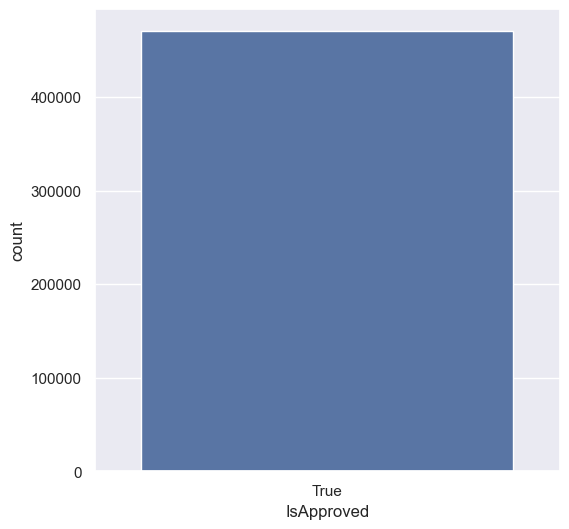

In [72]:
plt.figure(figsize=(6, 6))
sns.countplot(x = 'IsApproved', data = merged_df)

In [73]:
merged_df.drop(['IsOriginated'], axis=1, inplace=True)

In [74]:
merged_df.drop(['IsApproved'], axis=1, inplace=True)

#### Check whether records with the same loanid has the same loan status

In [75]:
def check_unique_loan_status(df):
    status_check = df.groupby('LoanID')['LoanStatus'].nunique().reset_index()
    
    multiple_status_ids = status_check[status_check['LoanStatus'] > 1]['LoanID']
    
    if not multiple_status_ids.empty:
        print("The following LoanIDs have multiple LoanStatuses:")
        for loan_id in multiple_status_ids:
            print(f"LoanID: {loan_id}")
            print(df[df['LoanID'] == loan_id][['LoanID', 'LoanStatus']])
    else:
        print("All LoanIDs have a unique LoanStatus")

In [76]:
check_unique_loan_status(merged_df)

All LoanIDs have a unique LoanStatus


In [77]:
df = merged_df.copy()
file_path = 'cleaned_data.csv'
df.to_csv(file_path, index=False)